## Import libraries and clean any missed data

- This model is used to check whether, at this stage, it will be possible to use machine learning in my project. If the score is low, we will proceed with user-fed prompts. i.e. if user too hot, mytemp + 1, until there is enough data about these changes. 

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression as LinReg
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 

In [82]:
users = pd.read_csv('usercleanmytemp.csv')

In [83]:
users = users.dropna()
users['dob'] = pd.to_datetime(users['dob'])

In [84]:
users.columns

Index(['user', 'gender', 'dob', 'age', 'bmi', 'currentlocation', 'currentcity',
       'currentcountry', 'sweats', 'coldhf', 'exercise', 'height_cm',
       'weight_kg', 'genscore', 'agescore', 'bmiscore', 'citymorningscore',
       'cityafternoonscore', 'citynightscore', 'sweatscore', 'coldhfscore',
       'exercisescore', 'mymorningtemp', 'myafternoontemp', 'mynighttemp'],
      dtype='object')

In [85]:
users['mytemp'] = round((users['mymorningtemp'] + users['myafternoontemp'] + users['mynighttemp'])/3).astype(int)
users['cityscore'] = round((users['citymorningscore'] + users['citymorningscore'] + users['citymorningscore'])/3).astype(int)
users = users[['gender','age','bmi','sweats','coldhf','exercise','height_cm','weight_kg','genscore','agescore','bmiscore','sweatscore','coldhfscore','exercisescore','mytemp','cityscore']]





### Use a correlation plot to check the colinearity between the target(mytemp) and the features

In [86]:
users.corr()

,age,height_cm,weight_kg,genscore,agescore,bmiscore,sweatscore,coldhfscore,exercisescore,mytemp,cityscore
age,1.000000,-0.006363,0.002564,-0.008768,-0.638638,0.001885,-0.241743,-0.269564,-0.389879,-0.114362,0.007355
height_cm,-0.006363,1.000000,0.487610,0.638007,-0.104176,0.017494,0.160209,-0.053233,0.037648,0.054936,-0.020914
weight_kg,0.002564,0.487610,1.000000,0.319139,-0.055384,0.340104,0.077977,-0.019639,0.027266,0.024713,-0.020001
genscore,-0.008768,0.638007,0.319139,1.000000,-0.142134,0.001751,0.276435,-0.079738,0.063573,0.108924,-0.013526
agescore,-0.638638,-0.104176,-0.055384,-0.142134,1.000000,-0.006963,0.248736,0.192132,0.138658,0.137107,0.005088
bmiscore,0.001885,0.017494,0.340104,0.001751,-0.006963,1.000000,-0.006866,-0.005347,0.012827,0.016398,-0.001886
sweatscore,-0.241743,0.160209,0.077977,0.276435,0.248736,-0.006866,1.000000,0.045379,0.076539,0.106770,-0.009334
coldhfscore,-0.269564,-0.053233,-0.019639,-0.079738,0.192132,-0.005347,0.045379,1.000000,0.102112,0.088220,-0.006828
exercisescore,-0.389879,0.037648,0.027266,0.063573,0.138658,0.012827,0.076539,0.102112,1.000000,0.060960,-0.004393
mytemp,-0.114362,0.054936,0.024713,0.108924,0.137107,0.016398,0.106770,0.088220,0.060960,1.000000,0.973765


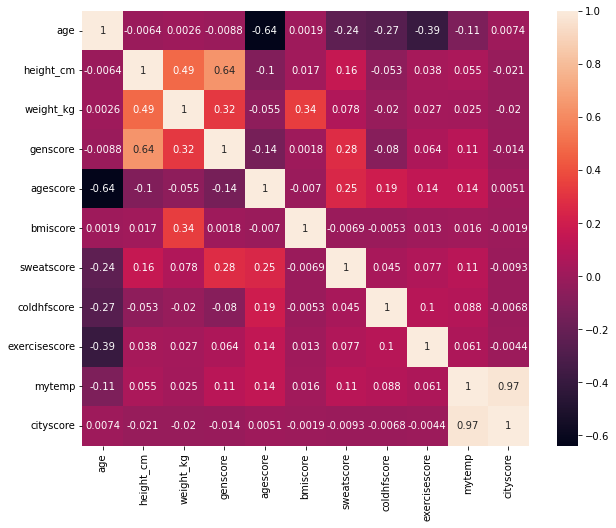

In [87]:
corr_matrix=users.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

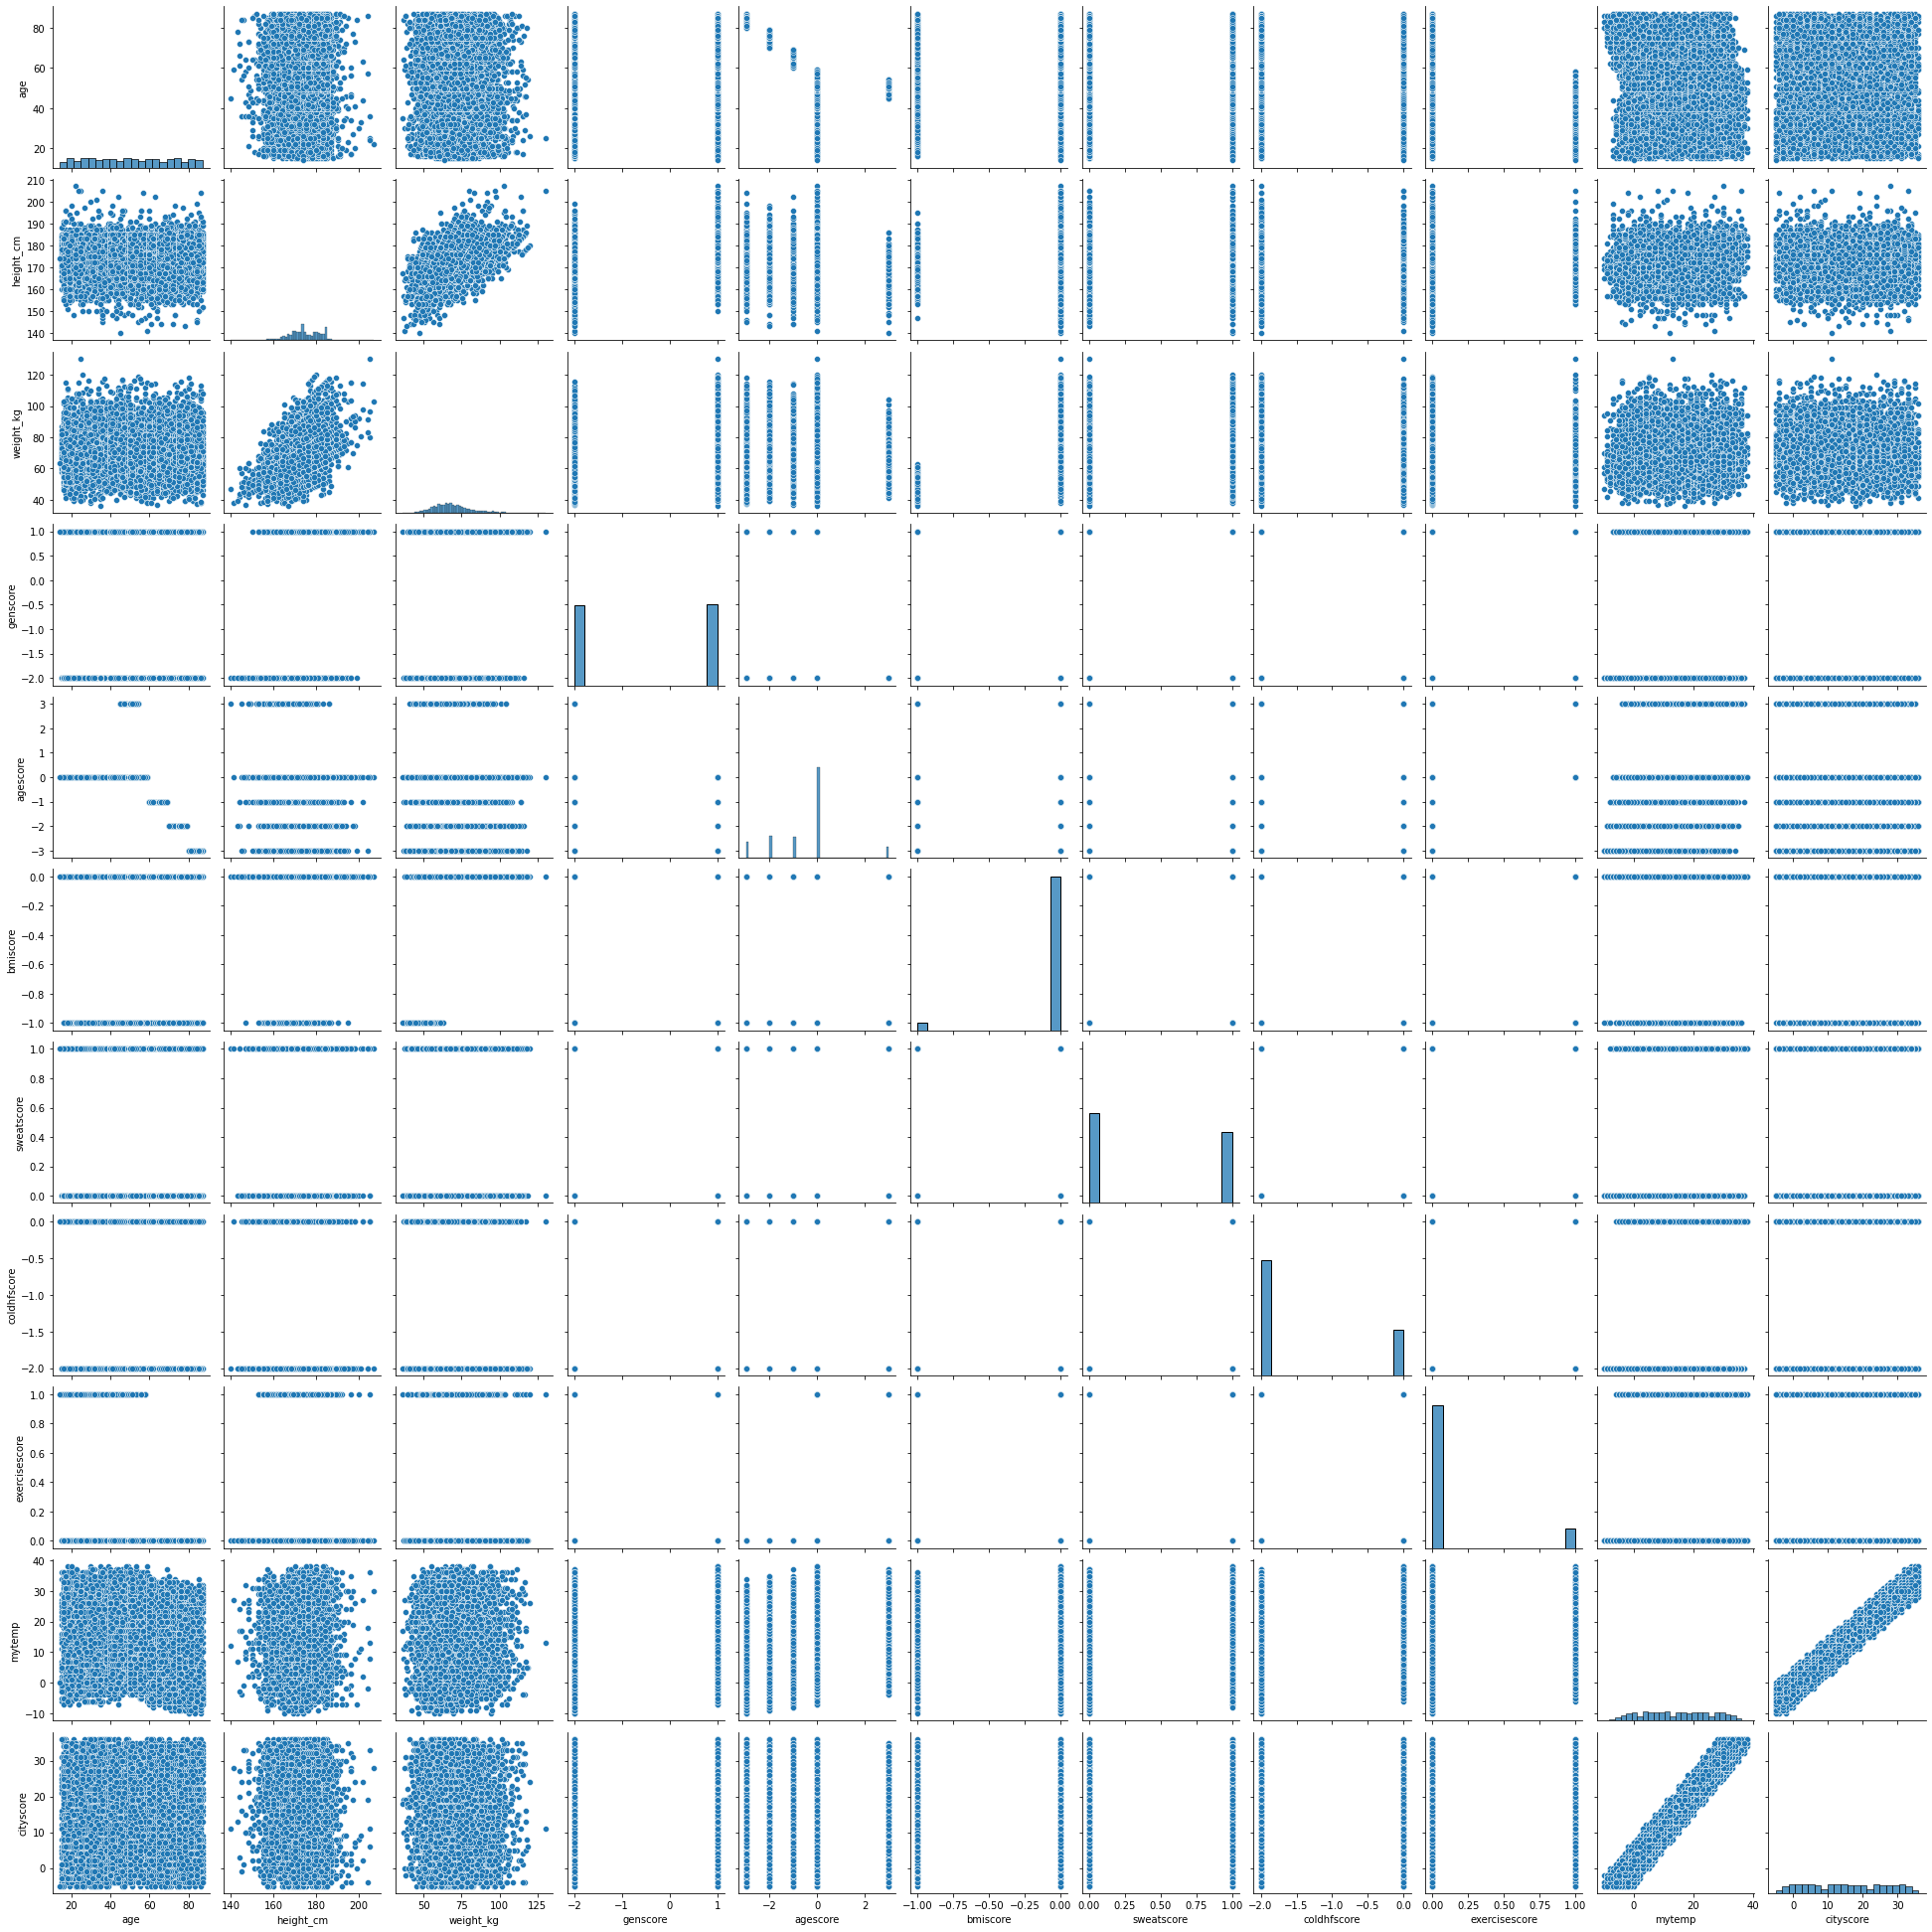

In [88]:
sns.pairplot(users)
plt.show()

Colinearity is quite low, existant, though. Weight & Age is also very consistent from 20 years, and weight very consistent too. This could cause problems

In [89]:


def histplot(x):
    for i in x.columns:
        plt.title(i, fontsize=16)
        plt.figure()
        plt.hist(x[i])

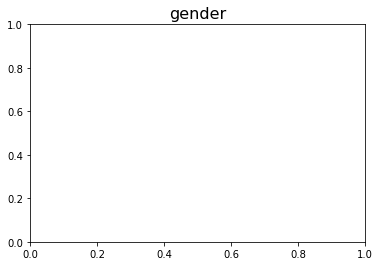

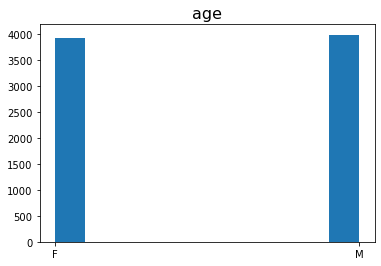

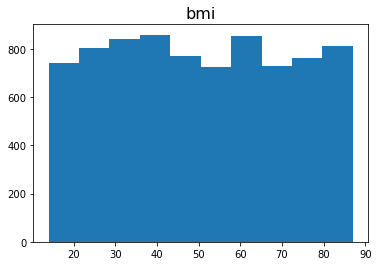

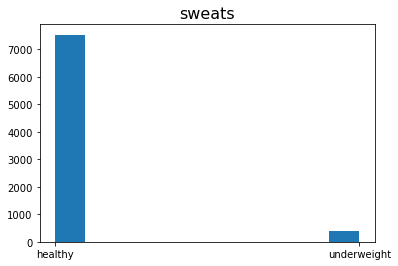

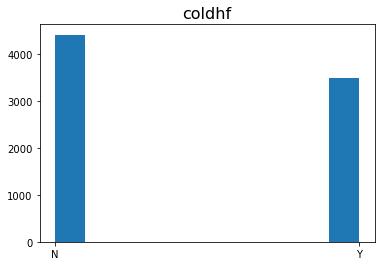

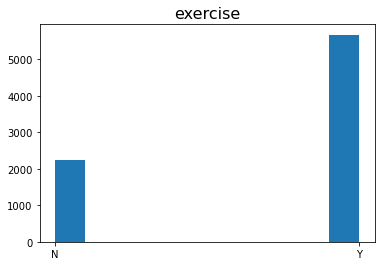

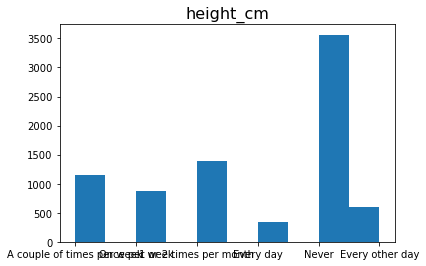

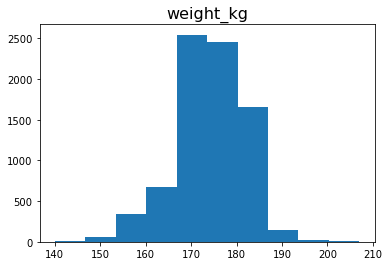

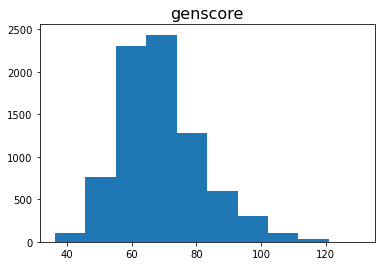

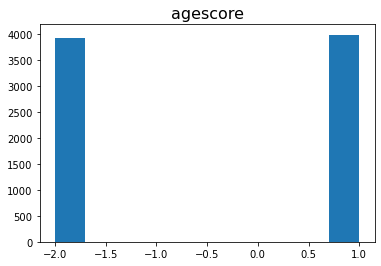

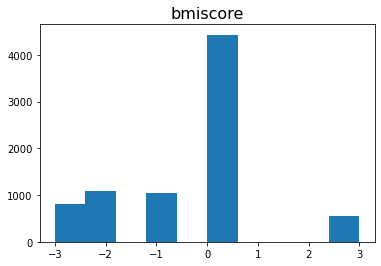

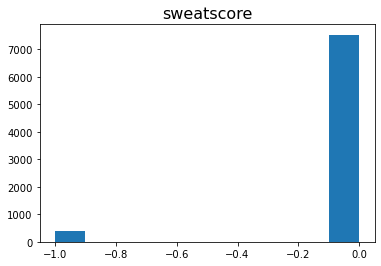

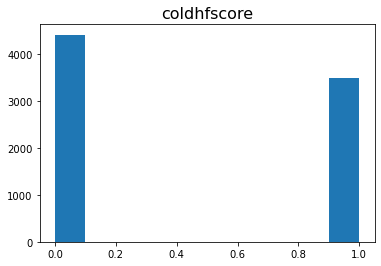

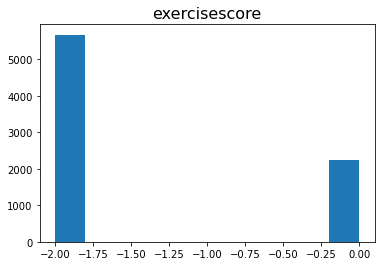

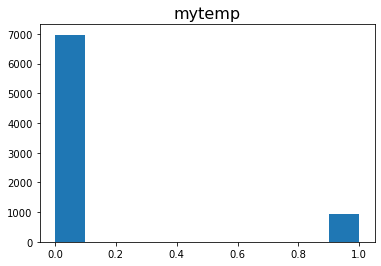

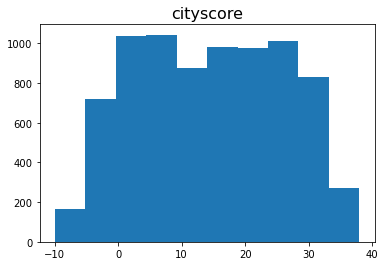

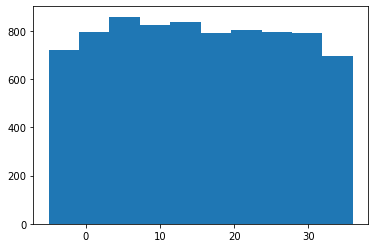

In [90]:
histplot(users)

In [91]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7913 entries, 0 to 7913
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         7913 non-null   object 
 1   age            7913 non-null   int64  
 2   bmi            7913 non-null   object 
 3   sweats         7913 non-null   object 
 4   coldhf         7913 non-null   object 
 5   exercise       7913 non-null   object 
 6   height_cm      7913 non-null   float64
 7   weight_kg      7913 non-null   float64
 8   genscore       7913 non-null   int64  
 9   agescore       7913 non-null   int64  
 10  bmiscore       7913 non-null   int64  
 11  sweatscore     7913 non-null   int64  
 12  coldhfscore    7913 non-null   int64  
 13  exercisescore  7913 non-null   int64  
 14  mytemp         7913 non-null   int64  
 15  cityscore      7913 non-null   int64  
dtypes: float64(2), int64(9), object(5)
memory usage: 1.3+ MB


### Xy Split

In [92]:
X = users.drop(columns=['mytemp'])
y = users['mytemp']

In [93]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

In [94]:
##########Cat/Num Split##########

#Train
X_train_numerical = X_train.select_dtypes(include=np.number)
X_train_categorical = X_train.select_dtypes(include=np.object)


#Test
X_test_numerical = X_test.select_dtypes(include=np.number)
X_test_categorical = X_test.select_dtypes(include=np.object)

/var/folders/sm/8s2c1j894rq6v788yfhxt27r0000gn/T/ipykernel_25835/3347826989.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train_categorical = X_train.select_dtypes(include=np.object)
/var/folders/sm/8s2c1j894rq6v788yfhxt27r0000gn/T/ipykernel_25835/3347826989.py:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test_categorical = X_test.select_dtypes(include=np.object)


In [95]:
##########Transform Categorical##########


#Train
xtraincord = X_train_categorical[['bmi','exercise']]
xtraincord['bmi'] = xtraincord['bmi'].map({'healthy':0.2,'underweight':-1})
xtraincord['exercise'] = xtraincord['exercise'].map({'Never':0,'1 or 2 times per month':0,'Once per week':0,'A couple of times per week':0,'Every other day':1,'Every day':1})


xtraincohe = X_train_categorical[['gender','coldhf']]

encoder = OneHotEncoder(drop='first').fit(xtraincohe)
encoded_for_p = encoder.transform(xtraincohe).toarray()
cols = encoder.get_feature_names(input_features=xtraincohe.columns)
onehot_encoded_for_p = pd.DataFrame(encoded_for_p, columns=cols)
onehot_encoded_for_p.head()
X_train_ohe = onehot_encoded_for_p

xtraincord = xtraincord.reset_index(drop = True)
X_train_ohe = X_train_ohe.reset_index(drop = True)
X_train_cat_encoded = pd.concat([xtraincord,X_train_ohe], axis = 1).reset_index(drop = True)


#Test
xtestcord = X_test_categorical[['bmi','exercise']]
xtestcord['bmi'] = xtestcord['bmi'].map({'healthy':0.2,'underweight':-1})
xtestcord['exercise'] = xtestcord['exercise'].map({'Never':0,'1 or 2 times per month':0,'Once per week':0,'A couple of times per week':0,'Every other day':1,'Every day':1})


xtestcohe = X_test_categorical[['gender','coldhf']]

encoded_for_p = encoder.transform(xtestcohe).toarray()
cols = encoder.get_feature_names(input_features=xtestcohe.columns)
onehot_encoded_for_p = pd.DataFrame(encoded_for_p, columns=cols)
onehot_encoded_for_p.head()
X_test_ohe = onehot_encoded_for_p


xtestcord = xtestcord.reset_index(drop = True)
X_test_ohe = X_test_ohe.reset_index(drop = True)
X_test_cat_encoded = pd.concat([xtestcord, X_test_ohe], axis = 1).reset_index(drop = True)


/var/folders/sm/8s2c1j894rq6v788yfhxt27r0000gn/T/ipykernel_25835/693348784.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtraincord['bmi'] = xtraincord['bmi'].map({'healthy':0.2,'underweight':-1})
/var/folders/sm/8s2c1j894rq6v788yfhxt27r0000gn/T/ipykernel_25835/693348784.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtraincord['exercise'] = xtraincord['exercise'].map({'Never':0,'1 or 2 times per month':0,'Once per week':0,'A couple of times per week':0,'Every other day':1,'Every day':1})
/opt/an

In [96]:
#Standardised Scaler
#Train
Standardtransformer = StandardScaler().fit(X_train_numerical)
x_train_standardized = Standardtransformer.transform(X_train_numerical)
x_train_standardized = pd.DataFrame(x_train_standardized,columns=X_train_numerical.columns)
x_train_standardized.head()



#Test
x_test_standardized = Standardtransformer.transform(X_test_numerical)
x_test_standardized = pd.DataFrame(x_test_standardized,columns=X_test_numerical.columns)
x_test_standardized.head()

#Determine Continuous Values

,age,height_cm,weight_kg,genscore,agescore,bmiscore,sweatscore,coldhfscore,exercisescore,cityscore
0,0.406823,-0.033371,-0.193777,-1.011120,0.368285,0.230368,-0.883794,-0.629624,-0.368003,1.750011
1,1.508109,0.617385,0.866686,0.989002,-1.781647,0.230368,-0.883794,-0.629624,-0.368003,0.329707
2,1.747519,-0.944428,-0.602252,-1.011120,-1.781647,0.230368,-0.883794,-0.629624,-0.368003,-0.824290
3,1.316581,1.137990,-1.741267,0.989002,-1.065003,-4.340882,-0.883794,-0.629624,-0.368003,-0.291676
4,0.885643,-0.814277,-0.107369,-1.011120,-0.348359,0.230368,-0.883794,-0.629624,-0.368003,1.661242


In [97]:
#Concat Categorical & Numerical Values

#Train
x_train_standardized = x_train_standardized.reset_index(drop = True)
X_train_cat_encoded = X_train_cat_encoded.reset_index(drop = True)
X_train_scaled = pd.concat([x_train_standardized, X_train_cat_encoded], axis = 1).reset_index(drop = True)


#Test
x_test_standardized = x_test_standardized.reset_index(drop = True)
X_test_cat_encoded = X_test_cat_encoded.reset_index(drop = True)
X_test_scaled = pd.concat([x_test_standardized, X_test_cat_encoded], axis = 1).reset_index(drop = True)


**Test the data against a linear regression model - if the r2 is too low, we will need to revert to the algorithm and user-prompted updates until we have enough of a pattern.**

In [98]:
linreg = LinReg()
linreg.fit(X_train_scaled,y_train)
y_pred_linreg = linreg.predict(X_test_scaled)

In [99]:
lm = linear_model.LinearRegression()

In [100]:
lm.fit(X_train_scaled,y_train)
print(lm.intercept_)
print(lm.coef_)

14.269898507812192
[-1.62656800e-03 -1.02529109e-03  1.01062385e-02  1.20189150e+00
  1.37888757e+00  2.00385253e-01  4.97857071e-01  7.38606645e-01
  2.97402708e-01  1.11773404e+01  5.26031800e-02  9.63911407e-02
  6.00909002e-01 -3.33024664e-01]


In [101]:
pred = lm.predict(X_test_scaled)

In [102]:
pred

array([31.82951914, 16.00288016,  0.08578985, ..., 22.93673715,
        1.10343944, 26.87571883])

In [103]:
train_r2 = linreg.score(X_train_scaled, y_train)
test_r2 = linreg.score(X_test_scaled, y_test)
print (f'Train R2: {train_r2} \nTest R2: {test_r2}')

Train R2: 0.9949022637747131 
Test R2: 0.9950140128726558


In [104]:
predictions_train = lm.predict(X_train_scaled)
r2_score(y_train, predictions_train)

0.9949022637747131

In [105]:
predictions_test = lm.predict(X_test_scaled)
r2_score(y_test, predictions_test)

0.9950140128726558

In [106]:
np.sqrt(mean_squared_error(y_test,predictions_test))

0.8195536815661641

Mean Squared error impressively low

**R2 is extremely low - with the algorithm i have already fitted, it would be better to use the rolling update to tweak user data as they give feedback if we base results on this model. We will, however see if we can enjoy more success with a random forest regressor**